## Feature Engineering
Based on EDA, there are several feature that will be added to achieve best metrics.

In [2]:
import pandas as pd
import numpy as np 
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
house_variables = joblib.load('../output/read_data/x_train.pkl')
house_target = joblib.load('../output/read_data/y_train.pkl')

In [5]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

In [6]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [7]:
def mathematical_transforms(df):
    df["LivLotRatio"] = df.GrLivArea / df.LotArea
    df["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    df["_OQuGLA"] = df.OverallQual * df.GrLivArea
    return df

def group_transforms(df):
    df["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return df

In [8]:
house_variables = clean(house_variables)
house_variables = impute(house_variables)

In [9]:
house_variables_transform = mathematical_transforms(house_variables)
house_variables_transform = group_transforms(house_variables_transform)

In [10]:
# Getting non-categorical variables
# Need more sanity check
non_categorical_cols = []
columns = house_variables_transform.columns
for col in columns:
    if house_variables_transform[col].dtype != 'object':
        non_categorical_cols.append(col)
print('\n'.join(non_categorical_cols))

house_variables_transform_non_cat = house_variables_transform[non_categorical_cols]
house_variables_transform_cat = house_variables_transform[[x for x in columns if x not in non_categorical_cols]]

Id
MSSubClass
LotFrontage
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
FirstFlrSF
SecondFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
Threeseasonporch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
LivLotRatio
Spaciousness
_OQuGLA
MedNhbdArea


In [11]:
house_df = pd.concat([house_variables_transform_non_cat, house_target], axis=1, join='inner')

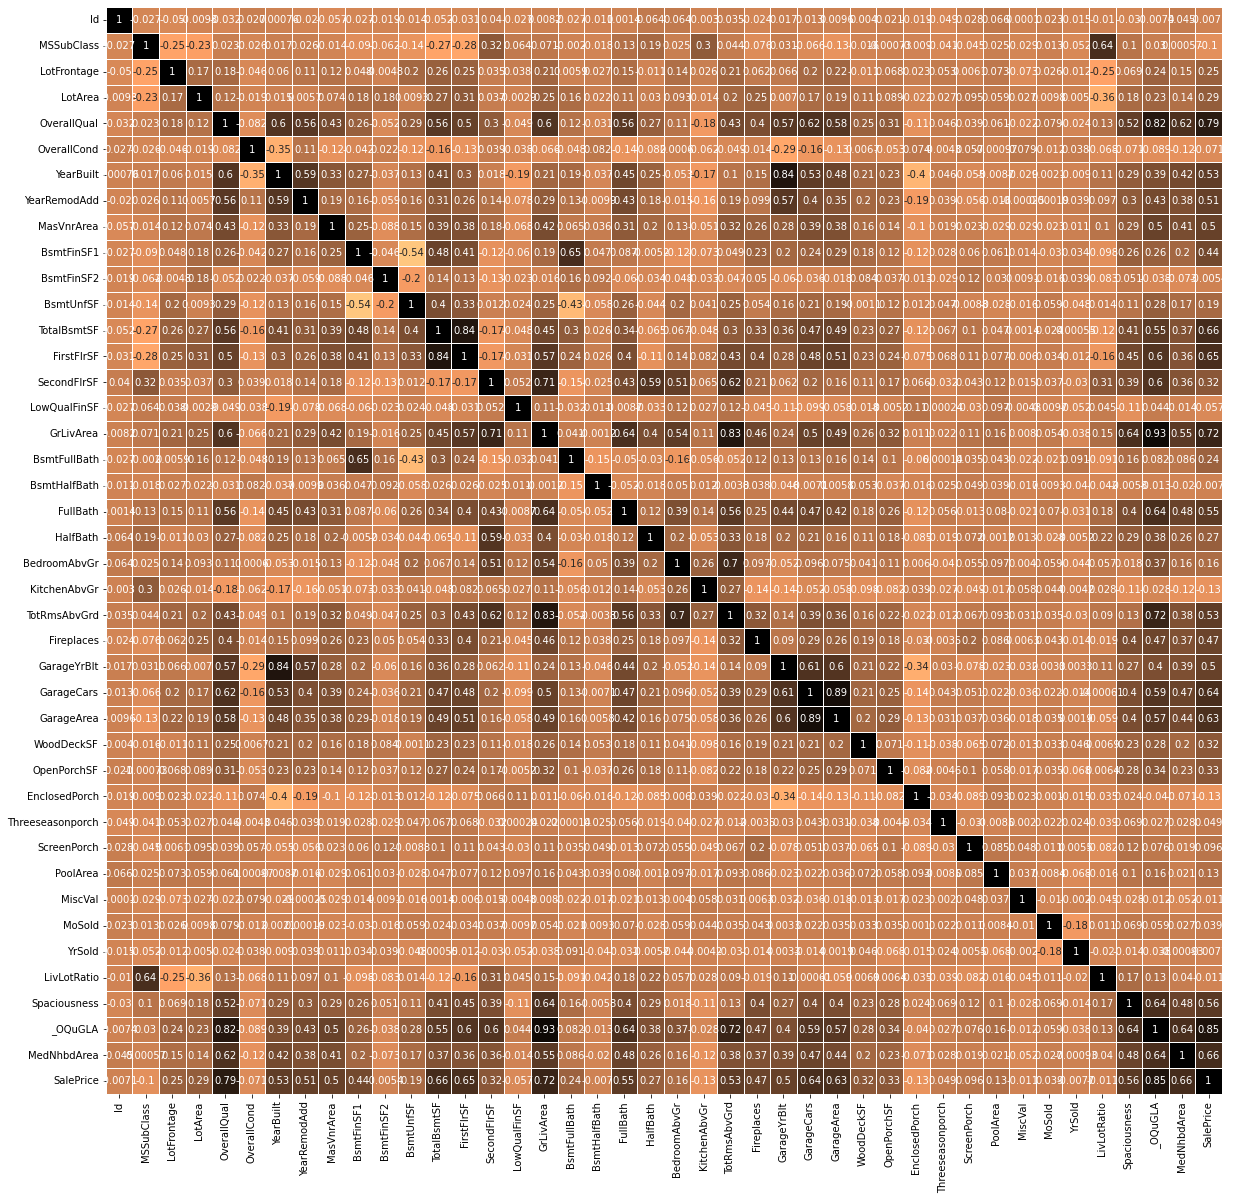

In [12]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(house_df.corr(), annot=True, linewidths=.5, ax=ax, cbar=False, cmap=plt.cm.copper_r)
plt.show()

In [14]:
corr_house = house_df.corr()

In [19]:
corr_house["SalePrice"].sort_values().head(10)

EnclosedPorch   -0.133770
KitchenAbvGr    -0.128890
MSSubClass      -0.103923
OverallCond     -0.071482
LowQualFinSF    -0.057369
LivLotRatio     -0.011495
MiscVal         -0.011085
YrSold          -0.007730
Id              -0.007116
BsmtHalfBath    -0.006978
Name: SalePrice, dtype: float64

In [18]:
corr_house["SalePrice"].sort_values().tail(10)

Spaciousness    0.561404
GarageArea      0.633876
GarageCars      0.644734
FirstFlrSF      0.645969
MedNhbdArea     0.661219
TotalBsmtSF     0.663825
GrLivArea       0.722767
OverallQual     0.793937
_OQuGLA         0.851017
SalePrice       1.000000
Name: SalePrice, dtype: float64

### Result of Feature Engineering
- Looks like the new feature `_OQuGLA` and `MedNhbdArea` get a high correlation with SalePrice
- If we take 0.5 as threshold, we can considering these feature for modelling stage
    - GarageArea      
    - GarageCars      
    - FirstFlrSF      
    - MedNhbdArea     
    - TotalBsmtSF     
    - GrLivArea      
    - OverallQual    
    - _OQuGLA        

- `MedNhbdArea` came from `GrLivArea` median of the data that have same`Neighborhood`, due to business and deployment setting, we only accept 1 data and cant have much features as input. 
- So we just use six feature as input user, `GarageArea`, `GarageCars`, `FirstFlrSF`, `TotalBsmtSF`, `GrLivArea`, `OverallQual`. 
- `_OQuGLA` came from multiplying `OverallQual` and `GrLivArea` since it dont need more input from user, we will include it in training stage